<a href="https://colab.research.google.com/github/sriyamistry0-lang/GenTen/blob/main/NETosis_Analysis_SET2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install GEOparse gseapy pandas seaborn matplotlib scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 19.2 MB/s eta 0:00:00


In [4]:
!pip uninstall -y scipy
!pip install scipy==1.11.4
!pip install GEOparse gseapy pandas seaborn matplotlib

Found existing installation: scipy 1.16.3
Uninstalling scipy-1.16.3:
  Successfully uninstalled scipy-1.16.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 94.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
libpysal 4.14.0 requires scipy>=1.12.0, but you have scipy 1.11.4 which is incomp

Starting analysis for GSE69686...


2026-01-20 06:30:00,340 [WARNING] Found duplicated gene names, values averaged by gene names!


Success! Matrix now has 20510 valid gene rows.
Sample genes: ['Q5VT23_HUMAN', 'OR4F5', 'OR4F29 /// OR4F16 /// OR4F3', 'FA87B_HUMAN', 'Q96BN7_HUMAN']
Target genes found in data: ['PADI4', 'CYBB', 'MPO', 'CLEC7A', 'MAP2K1', 'RAF1']
Calculating pathway scores... this may take a moment.


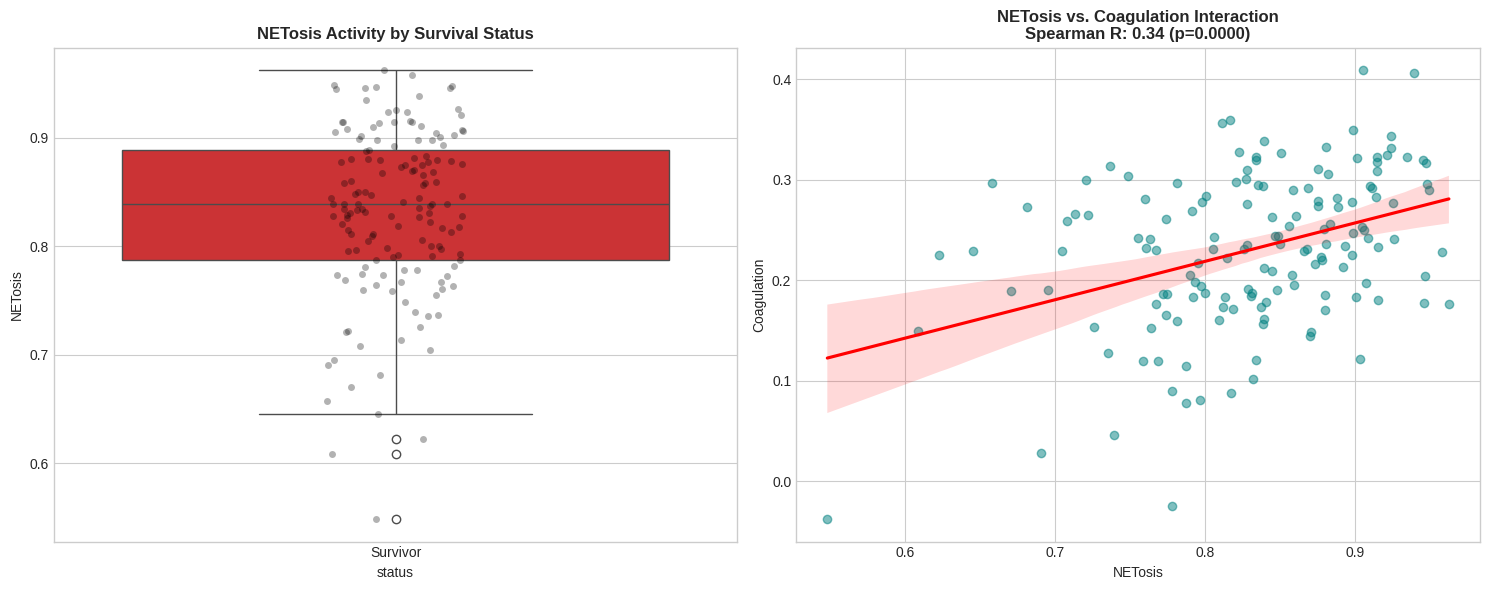

✅ Analysis Complete!
Final dataset contains 149 samples.


In [7]:
import GEOparse
import gseapy as gp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. Setup
gse_id = "GSE69686"
netosis_genes = ['PADI4' , 'CYBB', 'ELANE', 'MPO', 'CLEC7A', 'MAP2K1', 'RAF1']
coagulation_genes = ['F3', 'SERPINE1', 'PLAT', 'F2R', 'PLAUR', 'THBS1']

print(f"Starting analysis for {gse_id}...")

# 2. Data Acquisition
gse = GEOparse.get_GEO(geo=gse_id, destdir="./", silent=True)
expr_matrix = gse.pivot_samples('VALUE')
metadata = gse.phenotype_data.copy()

# 3. Metadata Harmonization
def harmonizer(row):
    text = "".join(row.astype(str)).lower()
    if any(word in text for word in ['died', 'death','nonsurvivor', 'expired']):
        return 'NonSurvivor'
    return 'Survivor'

metadata['status'] = metadata.apply(harmonizer, axis=1)

# 4. Final Corrected Mapping for GSE69686
gpl_id = list(gse.gpls.keys())[0]
platform_table = gse.gpls[gpl_id].table

# Based on your output, the column name is exactly 'symbol'
symbol_col = 'symbol'

mapping = {}
for _, row in platform_table.iterrows():
    raw_val = str(row[symbol_col])
    # Clean up and ensure it's uppercase to match your gene lists
    clean_symbol = raw_val.strip().upper()
    mapping[str(row['ID'])] = clean_symbol

# Apply the mapping to the matrix
new_index = []
for probe_id in expr_matrix.index:
    gene_symbol = mapping.get(str(probe_id), "UNKNOWN")
    new_index.append(gene_symbol)

expr_matrix.index = new_index

# Filter out the junk (like '---', 'UNKNOWN', or empty values)
expr_matrix = expr_matrix[~expr_matrix.index.isin(["UNKNOWN", "---", "NAN", "NULL", ""])]

print(f"Success! Matrix now has {expr_matrix.shape[0]} valid gene rows.")
print(f"Sample genes: {expr_matrix.index[:5].tolist()}")

# Check if our target genes are actually there
test_genes = [g for g in netosis_genes if g.upper() in expr_matrix.index]
print(f"Target genes found in data: {test_genes}")


# 5. Pathway Scoring (ssGSEA)
print("Calculating pathway scores... this may take a moment.")
ssgsea_obj = gp.ssgsea(
    data=expr_matrix,
    gene_sets={
        'NETosis': [g.upper() for g in netosis_genes],
        'Coagulation' : [g.upper() for g in coagulation_genes]
    },
    sample_norm_method='rank',
    min_size=1,
    max_size=5000,
    outdir=None
)

# 6. Extraction (FIXED: Handling 'Names' vs 'Name' vs Index)
res_df = ssgsea_obj.res2d

# Let's find the sample name column automatically
sample_col = None
for col in ['Names', 'Name', 'Sample', 'index']:
    if col in res_df.columns:
        sample_col = col
        break

if sample_col is None:
    # If no column name matches, the samples are likely in the index
    res_df = res_df.reset_index()
    sample_col = 'index'

# Pivot the results
scores_df = res_df.pivot(index=sample_col, columns='Term', values='NES')

# 7. Integration & Cleanup
final_df = metadata.merge(scores_df, left_index=True, right_index=True)
final_df['NETosis'] = pd.to_numeric(final_df['NETosis'], errors='coerce')
final_df['Coagulation'] = pd.to_numeric(final_df['Coagulation'], errors='coerce')
final_df = final_df.dropna(subset=['NETosis', 'Coagulation'])

# 8. Statistics
from scipy.stats import spearmanr
corr_coeff, p_corr = spearmanr(final_df['NETosis'], final_df['Coagulation'])

# 9. Visualization
plt.style.use('seaborn-v0_8-whitegrid') # Makes it look professional
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot A: NETosis by Outcome
sns.boxplot(data=final_df, x='status', y='NETosis', hue='status', palette='Set1', legend=False, ax=ax1)
sns.stripplot(data=final_df, x='status', y='NETosis', color='black', alpha=0.3, ax=ax1)
ax1.set_title("NETosis Activity by Survival Status", fontweight='bold')

# Plot B: Pathway Interaction
sns.regplot(data=final_df, x='NETosis', y='Coagulation',
            scatter_kws={'alpha':0.5, 'color':'teal'},
            line_kws={'color':'red'}, ax=ax2)
ax2.set_title(f"NETosis vs. Coagulation Interaction\nSpearman R: {corr_coeff:.2f} (p={p_corr:.4f})", fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✅ Analysis Complete!")
print(f"Final dataset contains {len(final_df)} samples.")